# Ejemplos de Regresión en Finanzas y Clima con Interpretabilidad


---
## 📌 Introducción
En este notebook exploramos dos datasets públicos:


1. **Automobile (UCI)** → predicción de precios de autos (ejemplo de finanzas/valoración).
2. **Bike Sharing (UCI)** → predicción de demanda diaria de bicicletas en función de variables climáticas.


Compararemos dos modelos:
- **Regresión Lineal** (modelo interpretable, baseline)
- **Random Forest** (modelo más flexible, captura no linealidades)


Además, exploraremos **interpretabilidad** con:
- Feature Importances (Random Forest)
- Permutation Importance
- SHAP values
- LIME


---

In [13]:
import io
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/home/mynorjrv/Documents/mystuff/learning-machine-learning/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        random_state=42, n_estimators=200
    )
}

## Ejemplo de valoración de autos

In [5]:
auto_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
auto_columns = [
"symboling", "normalized_losses", "make", "fuel_type", "aspiration",
"num_doors", "body_style", "drive_wheels", "engine_location", "wheel_base",
"length", "width", "height", "curb_weight", "engine_type", "num_cylinders",
"engine_size", "fuel_system", "bore", "stroke", "compression_ratio",
"horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"
]

auto = pd.read_csv(auto_url, names=auto_columns, na_values="?")
auto = auto.dropna(subset=["price"])
auto["price"] = auto["price"].astype(float)

X_auto = auto.drop("price", axis=1)
y_auto = auto["price"]

num_cols_auto = X_auto.select_dtypes(include=["int64", "float64"]).columns
cat_cols_auto = X_auto.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_auto = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_auto),
        ("cat", categorical_transformer, cat_cols_auto)
    ]
)

In [7]:
print("--- Resultados en Dataset Automobile (Finanzas) ---")
for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor_auto),
            ("model", model)
        ]
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_auto, y_auto, test_size=0.2, random_state=42
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\nModelo: {name}")
    print("RMSE:", mean_squared_error(y_test, y_pred)) # , squared=False))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))

--- Resultados en Dataset Automobile (Finanzas) ---

Modelo: LinearRegression
RMSE: 10576265.63870383
MAE: 1972.1465065653358
R²: 0.9135550094847553

Modelo: RandomForest
RMSE: 8848236.0605072
MAE: 1886.835827235772
R²: 0.9276790401776509


## Ejemplo de demanda de bibicletas

In [8]:
bike_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
r = requests.get(bike_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
day = pd.read_csv(z.open("day.csv"))

X_bike = day.drop(columns=["instant", "dteday", "casual", "registered", "cnt"])
y_bike = day["cnt"]

num_cols_bike = X_bike.select_dtypes(include=["int64", "float64"]).columns
cat_cols_bike = X_bike.select_dtypes(include=["object", "category"]).columns

preprocessor_bike = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_bike),
        ("cat", categorical_transformer, cat_cols_bike)
    ]
)

In [9]:
print("--- Resultados en Dataset Bike Sharing (Clima) ---")
for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor_bike),
            ("model", model)
        ]
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_bike, y_bike, test_size=0.2, random_state=42
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\nModelo: {name}")
    print("RMSE:", mean_squared_error(y_test, y_pred)) #, squared=False))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))

--- Resultados en Dataset Bike Sharing (Clima) ---

Modelo: LinearRegression
RMSE: 691035.0082022651
MAE: 617.3930656443371
R²: 0.8276670090367212

Modelo: RandomForest
RMSE: 451486.3999746599
MAE: 425.95302721088433
R²: 0.8874065701978118


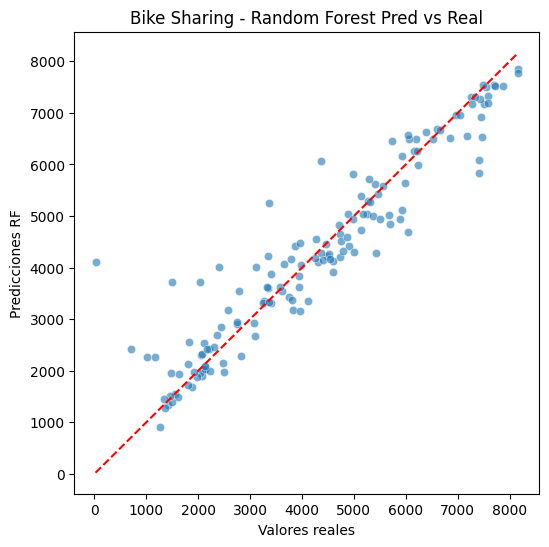

In [10]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_bike),
        ("model", RandomForestRegressor(
            random_state=42, n_estimators=200
        ))
    ]
)
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones RF")
plt.title("Bike Sharing - Random Forest Pred vs Real")
plt.show()

## Interpretabilidad(?)

### Feature Importance

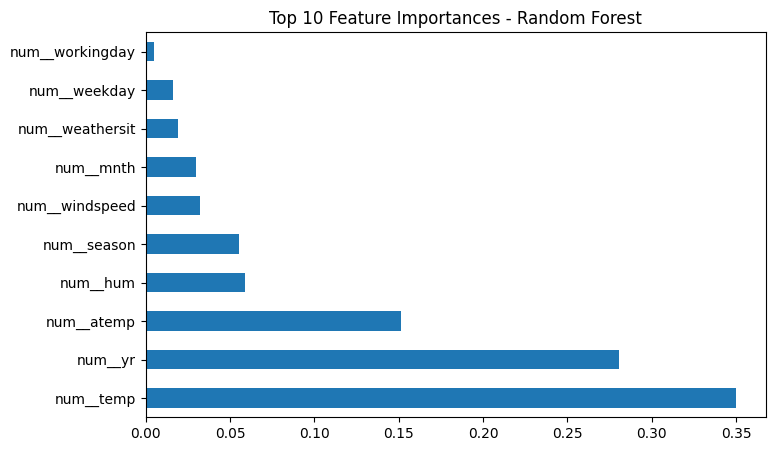

In [11]:
feature_names = (
    rf_pipeline
    .named_steps["preprocessor"]
    .get_feature_names_out(
        num_cols_bike.tolist()
        + cat_cols_bike.tolist()
    )
)

importances = rf_pipeline.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

### Permutation Importance

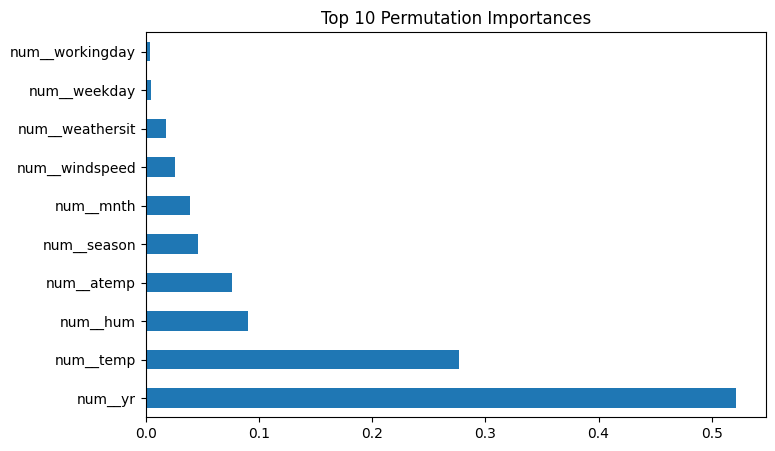

In [12]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
perm_importances.head(10).plot(kind="barh")
plt.title("Top 10 Permutation Importances")
plt.show()

### Shap

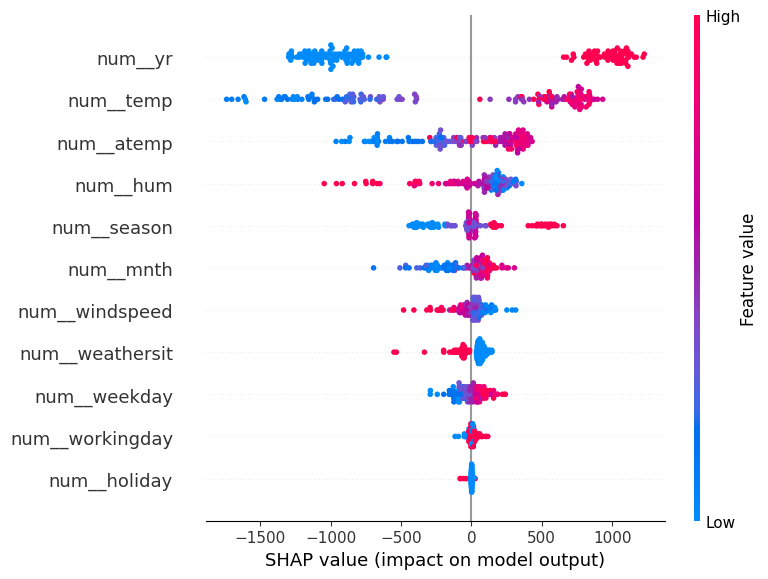

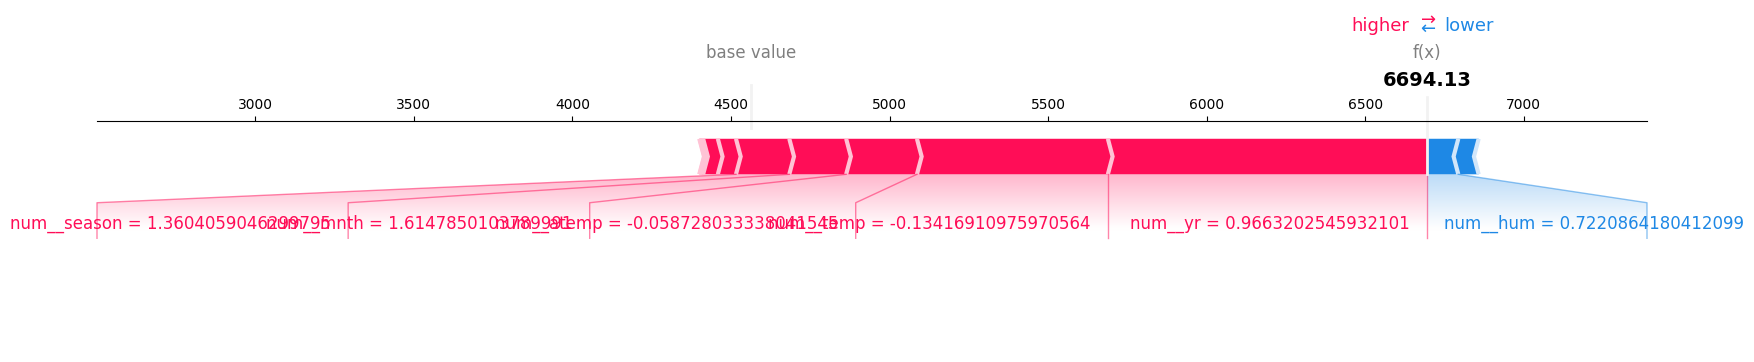

In [14]:
rf_model = rf_pipeline.named_steps["model"]
X_test_transformed = rf_pipeline.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

# Resumen global
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Ejemplo puntual
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test_transformed[0,:],
    feature_names=feature_names,
    matplotlib=True
)

### lime

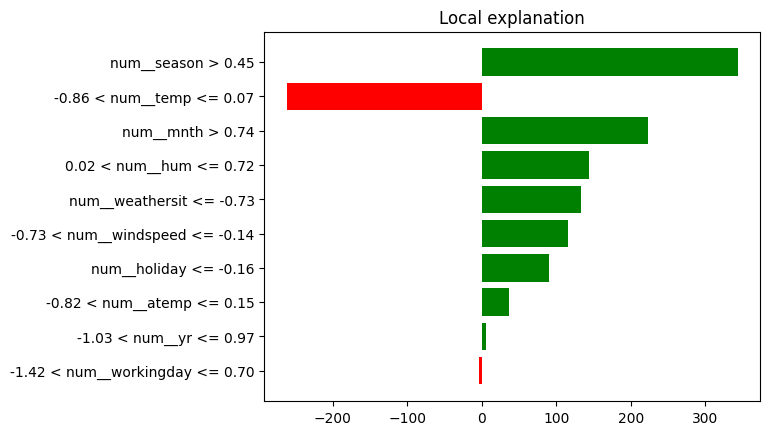

In [15]:
from lime.lime_tabular import LimeTabularExplainer

X_train_transformed = rf_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_transformed = rf_pipeline.named_steps["preprocessor"].transform(X_test)

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_transformed),
    feature_names=feature_names,
    class_names=["cnt"],
    mode="regression"
)

i = 0 # fila de ejemplo
exp = explainer_lime.explain_instance(
    X_test_transformed[i],
    rf_pipeline.named_steps["model"].predict,
    num_features=10
)

exp.as_pyplot_figure()
plt.show()